In [1]:
"""
MFP PyTorch Demo - Jupyter Notebook版本（完整版）
直接在notebook中显示SVG可视化结果
支持canvas_width和canvas_height的Lookup方法
"""

# ============================================================
# Cell 1: 导入依赖
# ============================================================
import json
import itertools
import logging
from pathlib import Path
from typing import Dict, List, Optional

import torch
import numpy as np
from IPython.display import display, HTML
import matplotlib.pyplot as plt

# 导入自定义模块
from models_pytorch import MFP
from dataset import DesignLayoutDataset
from svg_builder_pytorch import SVGBuilder
from retriever_pytorch import ImageRetriever, TextRetriever

# 配置日志
logging.basicConfig(level=logging.INFO, format='%(levelname)s: %(message)s')
logger = logging.getLogger(__name__)

# 设置随机种子
torch.manual_seed(0)
np.random.seed(0)

print("✓ 导入完成")


# ============================================================
# Cell 2: 配置参数
# ============================================================
class DemoConfig:
    """演示配置"""
    def __init__(self):
        self.ckpt_dir = "/home/dell/Project-HCL/BaseLine/flexdm_pt/chechpoints"
        self.dataset_name = "crello_json"
        self.db_root = "/home/dell/Project-HCL/BaseLine/flexdm_pt/data/crello_json"
        self.batch_size = 20
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        
        # 任务类型: elem, pos, attr, txt, img
        self.target_task = "pos"
        
        # 列名配置
        self.column_names = {
            "txt": ["gt-layout", "gt-visual", "input", "pred"],
            "img": ["gt-layout", "gt-visual", "input", "pred"],
            "attr": ["gt-layout", "gt-visual", "input", "pred"],
            "pos": ["gt-layout", "gt-visual", "pred-layout", "pred-visual"],
            "elem": ["gt-layout", "gt-visual", "input-layout", "input-visual", "pred-layout", "pred-visual"],
        }
        
        # 属性分组
        self.attribute_groups = {
            "type": ["type"],
            "pos": ["left", "top", "width", "height"],
            "attr": ["opacity", "color", "font_family"],
            "img": ["image_embedding"],
            "txt": ["text_embedding"],
        }

config = DemoConfig()
print(f"✓ 配置完成")
print(f"  - 设备: {config.device}")
print(f"  - 任务: {config.target_task}")
print(f"  - 批次大小: {config.batch_size}")


# ============================================================
# Cell 3: 类型映射工具
# ============================================================
DEFAULT_TYPE_MAPPING = {
    0: '',
    1: 'svgElement',
    2: 'textElement',
    3: 'imageElement',
    4: 'coloredBackground',
    5: 'maskElement',
    6: 'humanElement',
}

def load_type_mapping_from_vocab(vocab_file: str) -> Dict[int, str]:
    """从vocabulary.json加载类型映射"""
    return DEFAULT_TYPE_MAPPING

    # try:
    #     with open(vocab_file, 'r') as f:
    #         vocab = json.load(f)
        
    #     type_vocab = vocab.get('type', {})
        
    #     if isinstance(type_vocab, dict):
    #         type_list = sorted(type_vocab.keys())
    #     elif isinstance(type_vocab, list):
    #         type_list = type_vocab
    #     else:
    #         return DEFAULT_TYPE_MAPPING
        
    #     id_to_name = {0: ''}
    #     for i, name in enumerate(type_list):
    #         id_to_name[i + 1] = name
        
    #     print("✓ 类型映射:")
    #     for idx, name in sorted(id_to_name.items()):
    #         if name:
    #             print(f"    {idx}: {name}")
        
    #     return id_to_name
        
    # except Exception as e:
    #     print(f"警告: 加载类型映射失败 ({e})，使用默认映射")
    #     return DEFAULT_TYPE_MAPPING


def load_font_mapping_from_dataset(dataset) -> Dict[int, str]:
    """从数据集加载字体映射"""
    if hasattr(dataset, 'idx_to_font'):
        return dataset.idx_to_font
    return {}


def load_canvas_mappings_from_dataset(dataset) -> tuple:
    """从数据集加载canvas尺寸映射"""
    width_mapping = {}
    height_mapping = {}
    
    if hasattr(dataset, 'idx_to_width'):
        width_mapping = dataset.idx_to_width
    
    if hasattr(dataset, 'idx_to_height'):
        height_mapping = dataset.idx_to_height
    
    return width_mapping, height_mapping


# ============================================================
# Cell 4: 数据处理工具
# ============================================================
def _extract_scalar(tensor):
    """从张量中提取标量值"""
    if tensor.dim() == 0:
        return tensor.item()
    elif tensor.dim() == 1:
        if tensor.size(0) == 1:
            return tensor[0].item()
        else:
            return tensor.argmax().item()
    else:
        return tensor.argmax(dim=-1)[0].item() if tensor.size(0) > 0 else 0


def tensor_to_list(
    data: Dict,
    type_mapping: Dict[int, str],
    font_mapping: Optional[Dict[int, str]] = None,
    width_mapping: Optional[Dict[int, int]] = None,
    height_mapping: Optional[Dict[int, int]] = None,
    bins: int = 64  # 离散化的bins数量
) -> List[Dict]:
    """将批次张量转换为样本列表（支持canvas Lookup）"""
    batch_size = data['length'].size(0)
    items = []
    
    # 位置字段的去离散化参数
    position_spec = {
        'min': 0.0,
        'max': 1.0,
        'bins': bins
    }
    scale = (position_spec['max'] - position_spec['min']) / (position_spec['bins'] - 1.0)
    
    for i in range(batch_size):
        # Canvas尺寸 - 从索引转换回实际值
        if 'canvas_width' in data:
            width_idx = data['canvas_width'][i].item()
            if width_mapping and width_idx in width_mapping:
                canvas_w = width_mapping[width_idx]
            else:
                canvas_w = 800
        else:
            canvas_w = 800
        
        if 'canvas_height' in data:
            height_idx = data['canvas_height'][i].item()
            if height_mapping and height_idx in height_mapping:
                canvas_h = height_mapping[height_idx]
            else:
                canvas_h = 600
        else:
            canvas_h = 600
        
        item = {
            'id': data['id'][i] if 'id' in data else f'sample_{i}',
            'canvas_width': canvas_w,
            'canvas_height': canvas_h,
            'length': data['length'][i].item(),
            'elements': []
        }
        
        num_elements = item['length']
        
        for j in range(num_elements):
            element = {}
            
            for key, value in data.items():
                if key in ['id', 'length', 'canvas_width', 'canvas_height']:
                    continue
                
                if not torch.is_tensor(value):
                    continue
                
                if value.dim() >= 2 and value.size(1) > j:
                    elem_value = value[i, j]
                    
                    if key == 'type':
                        type_id = _extract_scalar(elem_value)
                        element[key] = type_mapping.get(int(type_id), '')
                        continue
                    
                    if key == 'font_family' and font_mapping:
                        font_id = _extract_scalar(elem_value)
                        element[key] = font_mapping.get(int(font_id), 'Arial')
                        continue
                    
                    # 位置和尺寸：离散化索引 -> 归一化值 (0-1)
                    if key in ['left', 'top', 'width', 'height']:
                        discrete_idx = _extract_scalar(elem_value)
                        # 去离散化：index -> normalized value
                        normalized_val = scale * discrete_idx + position_spec['min']
                        element[key] = float(np.clip(normalized_val, 0.0, 1.0))
                        continue
                    
                    if key == 'color':
                        if elem_value.dim() >= 1 and elem_value.size(-1) >= 3:
                            element[key] = elem_value[:3].cpu().numpy().tolist()
                        else:
                            element[key] = [128, 128, 128]
                        continue
                    
                    if key in ['opacity']:
                        element[key] = _extract_scalar(elem_value)
                        continue
                    
                    if 'embedding' in key:
                        element[key] = elem_value.cpu().numpy()
                        continue
                    
                    if key == 'uuid':
                        element[key] = str(_extract_scalar(elem_value))
                        continue
                    
                    element[key] = _extract_scalar(elem_value)
            
            item['elements'].append(element)
        
        items.append(item)
    
    return items

def get_seq_mask(lengths: torch.Tensor, max_len: int = None) -> torch.Tensor:
    """生成序列掩码"""
    if lengths.dim() == 2:
        lengths = lengths.squeeze(-1)
    
    if max_len is None:
        max_len = lengths.max().item()
    
    mask = torch.arange(max_len, device=lengths.device).unsqueeze(0) < lengths.unsqueeze(1)
    return mask


def get_initial_masks(input_columns: Dict, seq_mask: torch.Tensor) -> Dict[str, torch.Tensor]:
    """初始化掩码字典"""
    masks = {}
    batch_size, seq_len = seq_mask.shape
    
    for key, column in input_columns.items():
        if column.get('is_sequence', False):
            masks[key] = torch.zeros_like(seq_mask, dtype=torch.bool)
        else:
            masks[key] = torch.ones(batch_size, dtype=torch.bool)
    
    return masks


def set_visual_default(item: Dict) -> Dict:
    """设置可视化默认值"""
    item = item.copy()
    for elem in item.get('elements', []):
        if 'color' not in elem or elem['color'] is None:
            elem['color'] = [128, 128, 128]
        if 'opacity' not in elem or elem['opacity'] is None:
            elem['opacity'] = 1.0
        if 'font_family' not in elem or elem['font_family'] is None:
            elem['font_family'] = 'Arial'
    return item


# ============================================================
# Cell 5: 模型相关
# ============================================================
def load_model(checkpoint_path: str, input_columns: Dict, device: str = 'cuda'):
    """加载PyTorch模型"""
    model = MFP(
        input_columns=input_columns,
        embed_dim=256,
        num_blocks=4,
        num_heads=8,
        dropout=0.1,
    )
    
    checkpoint = torch.load(checkpoint_path, map_location=device)
    state_dict = checkpoint.get('state_dict', checkpoint)
    
    missing, unexpected = model.load_state_dict(state_dict, strict=False)
    
    if missing:
        print(f"  警告: 缺失 {len(missing)} 个键")
    if unexpected:
        print(f"  警告: 多余 {len(unexpected)} 个键")
    
    model.to(device)
    model.eval()
    
    print(f"✓ 模型加载成功")
    return model


def apply_task_masks(
    example: Dict,
    input_columns: Dict,
    target_task: str,
    attribute_groups: Dict,
    device: str
) -> Dict[str, torch.Tensor]:
    """应用任务特定的掩码"""
    seq_mask = get_seq_mask(example['length'], example['left'].size(1))
    mfp_masks = get_initial_masks(input_columns, seq_mask)
    
    for key in mfp_masks.keys():
        if not input_columns[key].get('is_sequence', False):
            continue
        
        mask = mfp_masks[key].clone()
        
        if target_task == "elem":
            mask[:, 0] = True
        else:
            if key == "type":
                continue
            
            if target_task in attribute_groups:
                attr_keys = attribute_groups[target_task]
                if key in attr_keys:
                    mask = seq_mask.clone()
        
        mfp_masks[key] = mask.to(device)
    
    return mfp_masks


def model_inference_with_masks(model, inputs, masks):
    """使用掩码进行模型推理"""
    masked_inputs = {}
    for key, value in inputs.items():
        if key in masks and torch.is_tensor(value):
            mask = masks[key]
            if mask.any():
                masked_value = value.clone()
                if value.dim() == 3:
                    masked_value[mask] = 0
                masked_inputs[key] = masked_value
            else:
                masked_inputs[key] = value
        else:
            masked_inputs[key] = value
    
    outputs = model(masked_inputs)
    return outputs


# ============================================================
# Cell 6: 可视化主函数
# ============================================================
def visualize_reconstruction(
    model: torch.nn.Module,
    example: Dict,
    builders: Dict,
    config: DemoConfig,
    input_columns: Dict,
    type_mapping: Dict[int, str],
    font_mapping: Optional[Dict[int, str]] = None,
    width_mapping: Optional[Dict[int, int]] = None,
    height_mapping: Optional[Dict[int, int]] = None,
    bins: int = 64  # 添加bins参数
):
    """可视化重建结果"""
    svgs = []
    target_task = config.target_task
    
    # 转换为列表（传入bins参数）
    items = tensor_to_list(
        example, type_mapping, font_mapping, 
        width_mapping, height_mapping, bins
    )
    
    print(f"渲染 {len(items)} 个样本...")
    
    # GT Layout
    print("  - GT Layout")
    svgs.append([builders["layout"](item) for item in items])
    
    # GT Visual
    print("  - GT Visual")
    svgs.append([builders["visual"](item) for item in items])
    
    # 输入视图
    if target_task == "txt":
        print("  - Input (无文本)")
        svgs.append([builders["visual_wo_text"](item) for item in items])
    elif target_task == "img":
        print("  - Input (无图像)")
        svgs.append([builders["visual_wo_image"](item) for item in items])
    elif target_task == "attr":
        print("  - Input (默认属性)")
        svgs.append([builders["visual"](set_visual_default(item)) for item in items])
    
    # 应用掩码
    mfp_masks = apply_task_masks(
        example, input_columns, target_task,
        config.attribute_groups, config.device
    )
    
    # 元素级任务
    if target_task == "elem":
        example_copy = {}
        for key, value in example.items():
            if isinstance(value, torch.Tensor) and value.dim() >= 2 and value.size(1) > 1:
                indices = torch.where(~mfp_masks[key][0, :])[0]
                example_copy[key] = torch.index_select(value, 1, indices)
            else:
                example_copy[key] = value
        
        example_copy['length'] = example['length'] - 1
        
        # 转换时传入bins
        items_copy = tensor_to_list(
            example_copy, type_mapping, font_mapping,
            width_mapping, height_mapping, bins
        )
        svgs.append([builders["layout"](item) for item in items_copy])
        svgs.append([builders["visual"](item) for item in items_copy])
    
    # 模型预测
    print("  - 模型推理")
    with torch.no_grad():
        pred = model_inference_with_masks(model, example, mfp_masks)
    
    for key in example:
        if key not in pred:
            pred[key] = example[key]
    
    # 转换预测结果（传入bins）
    pred_items = tensor_to_list(
        pred, type_mapping, font_mapping,
        width_mapping, height_mapping, bins
    )
    
    if target_task in ["pos", "elem"]:
        print("  - Pred Layout")
        svgs.append([builders["layout"](item) for item in pred_items])
    
    print("  - Pred Visual")
    svgs.append([builders["visual"](item) for item in pred_items])
    
    print("✓ 渲染完成")
    
    return list(zip(*svgs))


# ============================================================
# Cell 7: 加载数据和模型
# ============================================================
print("="*80)
print("MFP PyTorch Demo - Jupyter Notebook版本")
print("="*80)

# 加载数据集
print("\n1. 加载数据集")
dataset = DesignLayoutDataset(
    config.db_root,
    split='test',
    max_length=20
)
print(f"✓ 数据集大小: {len(dataset)}")

# 加载类型映射
print("\n2. 加载类型映射")
vocab_file = Path(config.db_root).parent / "vocabulary.json"
type_mapping = load_type_mapping_from_vocab(str(vocab_file))

# 加载字体映射
print("\n3. 加载字体映射")
font_mapping = load_font_mapping_from_dataset(dataset)
if font_mapping:
    print(f"✓ 字体映射: {len(font_mapping)} 个字体")
else:
    print("  未找到字体映射")

# 加载Canvas尺寸映射
print("\n4. 加载Canvas尺寸映射")
width_mapping, height_mapping = load_canvas_mappings_from_dataset(dataset)
if width_mapping:
    print(f"✓ Width映射: {len(width_mapping)} 个尺寸")
    print(f"  范围: {min(width_mapping.values())} - {max(width_mapping.values())}")
else:
    print("  未找到width映射，使用默认值")

if height_mapping:
    print(f"✓ Height映射: {len(height_mapping)} 个尺寸")
    print(f"  范围: {min(height_mapping.values())} - {max(height_mapping.values())}")
else:
    print("  未找到height映射，使用默认值")

# 创建DataLoader
print("\n5. 创建DataLoader")
from torch.utils.data import DataLoader
from dataset import collate_fn

dataloader = DataLoader(
    dataset,
    batch_size=config.batch_size,
    shuffle=False,
    collate_fn=collate_fn
)

example = next(iter(dataloader))

for key in example:
    if torch.is_tensor(example[key]):
        example[key] = example[key].to(config.device)

print(f"✓ 批次形状: {example['left'].shape}")

# 加载模型配置
print("\n6. 加载模型配置")
input_columns_file = './input_columns_fixed.json'
with open(input_columns_file, 'r') as f:
    input_columns = json.load(f)
print(f"✓ 输入列数: {len(input_columns)}")

# 加载模型
print("\n7. 加载模型")
checkpoint_path = Path(config.ckpt_dir) / "best_pytorch.pth"
model = load_model(str(checkpoint_path), input_columns, config.device)

# 构建检索数据库
print("\n8. 构建检索数据库")
db_root = Path(config.db_root).parent / config.dataset_name

image_db = ImageRetriever(db_root, image_path=db_root / "images")
image_db.build("test")

text_db = TextRetriever(db_root, text_path=db_root / "texts")
text_db.build("test")

# 创建SVG构建器
print("\n9. 创建SVG构建器")
builders = {}

builders["layout"] = SVGBuilder(
    key='type',
    max_width=128,
    max_height=192,
    opacity=0.8,
)

patterns = [
    ("visual", image_db, text_db),
    ("visual_wo_text", image_db, None),
    ("visual_wo_image", None, text_db),
]

for (name, idb, tdb) in patterns:
    builders[name] = SVGBuilder(
        key='color',
        max_width=128,
        max_height=192,
        image_db=idb,
        text_db=tdb,
        render_text=(tdb is not None),
        opacity=1.0,
    )

print("✓ 构建器创建完成")


# ============================================================
# Cell 8: 运行可视化
# ============================================================
print("\n" + "="*80)
print(f"10. 开始可视化 - 任务: {config.target_task}")
print("="*80)


✓ 导入完成
✓ 配置完成
  - 设备: cuda
  - 任务: pos
  - 批次大小: 20
MFP PyTorch Demo - Jupyter Notebook版本

1. 加载数据集
加载数据: /home/dell/Project-HCL/BaseLine/flexdm_pt/data/crello_json/test.json
✓ 加载了 2248 个样本

构建查找表...
  Type词汇表: 7 个类型
  Canvas Width词汇表: 41 个尺寸
    范围: 160 - 3000
  Canvas Height词汇表: 46 个尺寸
    范围: 90 - 2560
  Font过滤: 290 -> 34 (频率>=500)
  Font词汇表: 37 个token (含特殊token)
✓ 数据集大小: 2248

2. 加载类型映射

3. 加载字体映射
✓ 字体映射: 37 个字体

4. 加载Canvas尺寸映射
✓ Width映射: 42 个尺寸
  范围: 160 - 3000
✓ Height映射: 47 个尺寸
  范围: 90 - 2560

5. 创建DataLoader


INFO: Building ImageRetriever index for test...


✓ 批次形状: torch.Size([20, 20, 1])

6. 加载模型配置
✓ 输入列数: 14

7. 加载模型

初始化MFP模型
初始化Encoder:
  color: Linear(3, 256)
  font_family: Embedding(37, 256)
  height: Embedding(66, 256)
  image_embedding: Linear(512, 256)
  left: Embedding(66, 256)
  opacity: Embedding(66, 256)
  text_embedding: Linear(512, 256)
  top: Embedding(66, 256)
  type: Embedding(8, 256)
  uuid: Embedding(1217, 256)
  width: Embedding(66, 256)
总计: 11 个特征

初始化Transformer:
  blocks=4, embed_dim=256, num_heads=8

初始化Decoder:
  color: Linear(256, 3)
  font_family: Linear(256, 35) -> (1, 35)
  height: Linear(256, 64) -> (1, 64)
  image_embedding: Linear(256, 512)
  left: Linear(256, 64) -> (1, 64)
  opacity: Linear(256, 64) -> (1, 64)
  text_embedding: Linear(256, 512)
  top: Linear(256, 64) -> (1, 64)
  type: Linear(256, 6) -> (1, 6)
  uuid: Linear(256, 1215) -> (1, 1215)
  width: Linear(256, 64) -> (1, 64)
总计: 11 个输出头

总参数数: 3,461,675

  警告: 缺失 101 个键
  警告: 多余 84 个键
✓ 模型加载成功

8. 构建检索数据库


INFO: Embeddings shape: (11306, 512), dtype: float32, C-contiguous: True
INFO: ✓ Built index with 11306 items
INFO: Building TextRetriever index for test...
INFO: Embeddings shape: (6973, 512), dtype: float32, C-contiguous: True
INFO: ✓ Built index with 6973 items



9. 创建SVG构建器
✓ 构建器创建完成

10. 开始可视化 - 任务: pos


渲染 20 个样本...
  - GT Layout
  - GT Visual
  - 模型推理
  - Pred Layout
  - Pred Visual
✓ 渲染完成

✓ 生成了 20 个样本的可视化结果
列名: ['gt-layout', 'gt-visual', 'pred-layout', 'pred-visual']

可视化结果:

Sample 0:



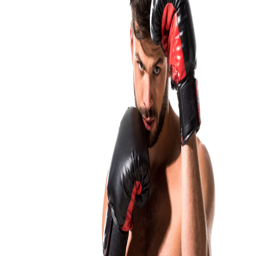
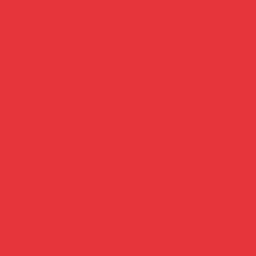
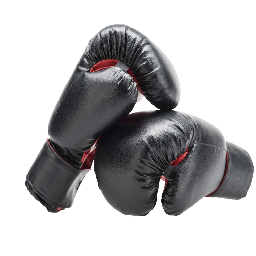
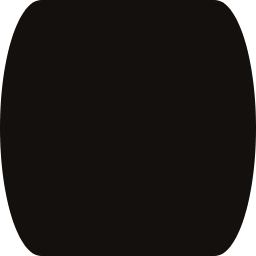
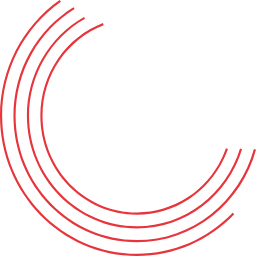
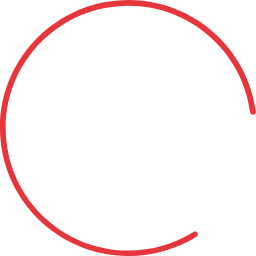
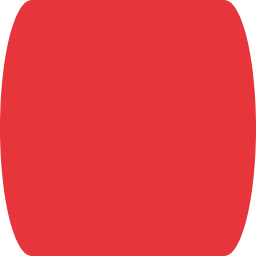
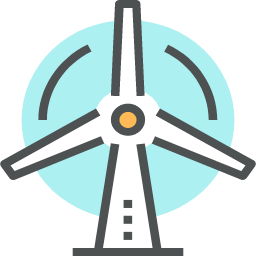
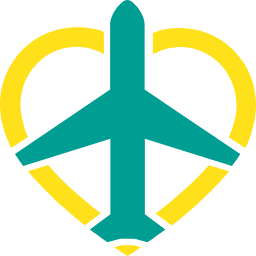
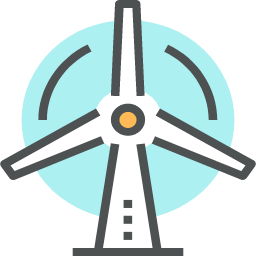
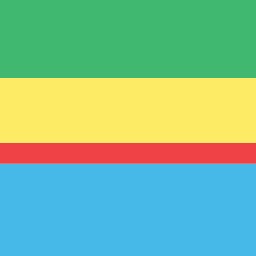
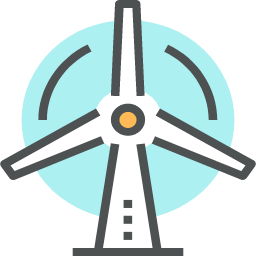


Sample 1:



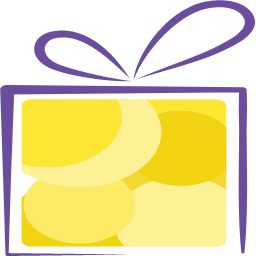
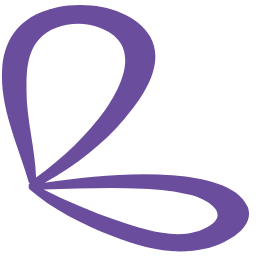
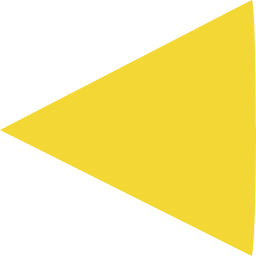
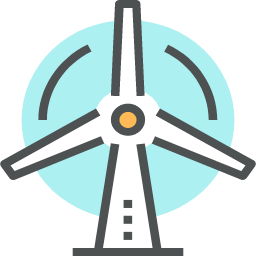
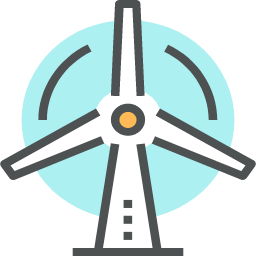
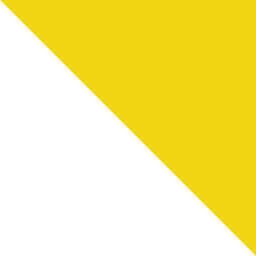


Sample 2:



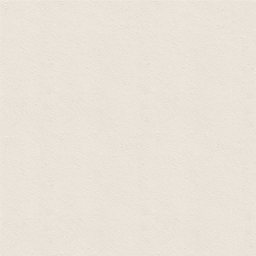
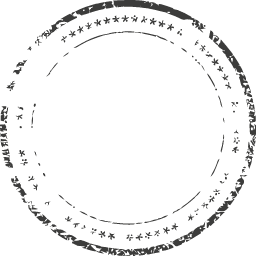
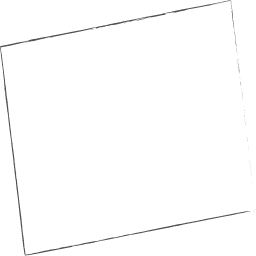
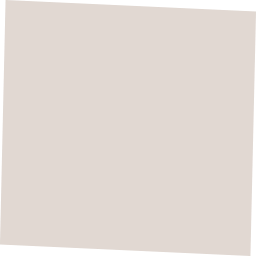
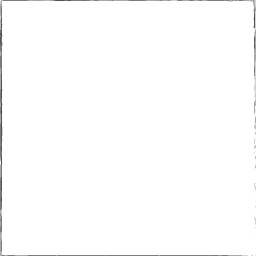
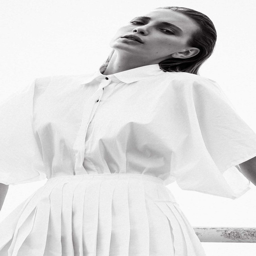
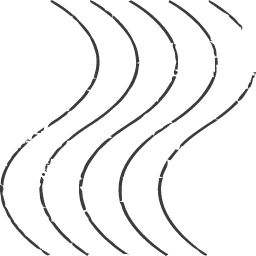
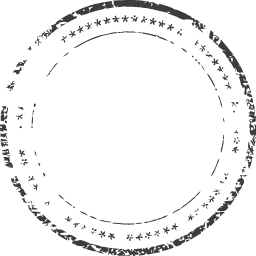
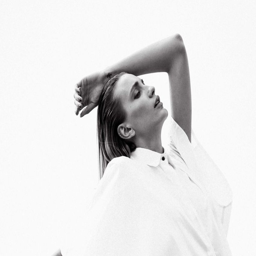
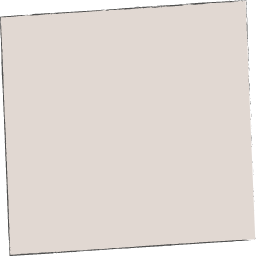
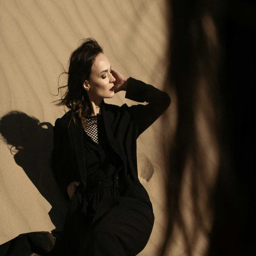
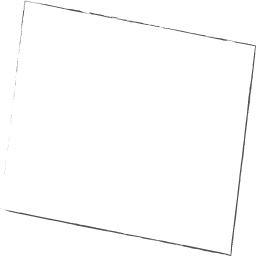
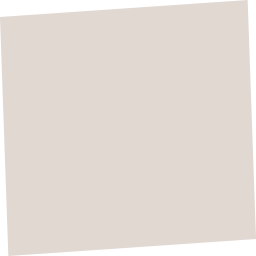
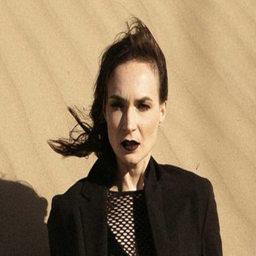
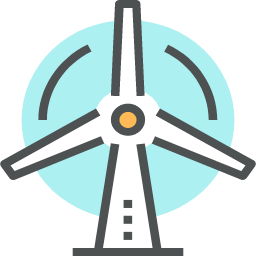
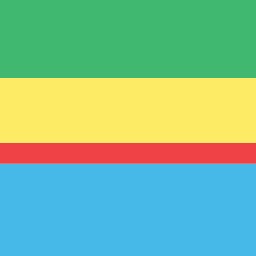
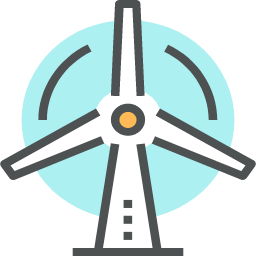
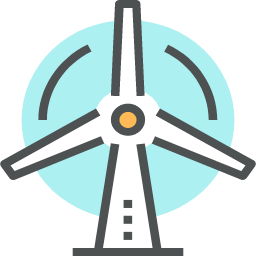
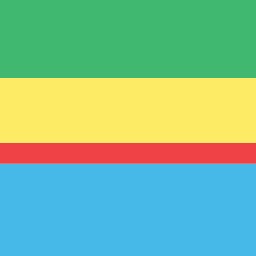
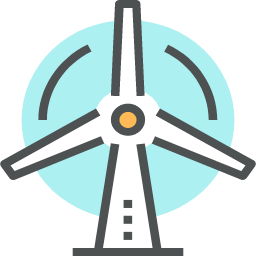
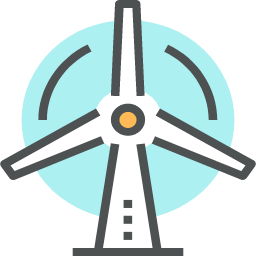


Sample 3:



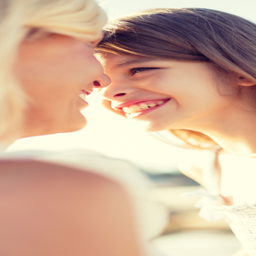
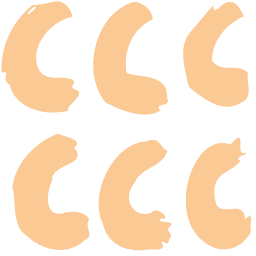
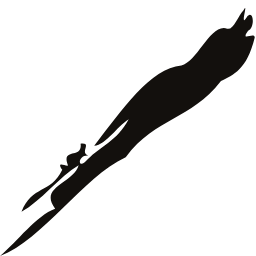
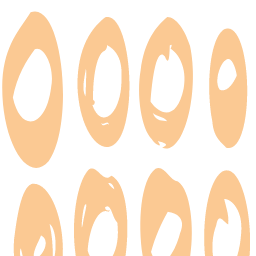
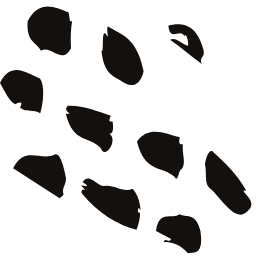
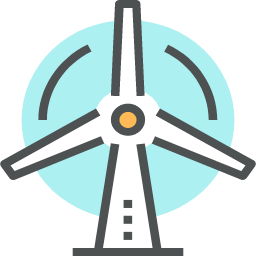
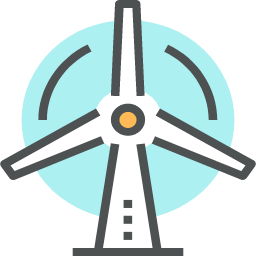
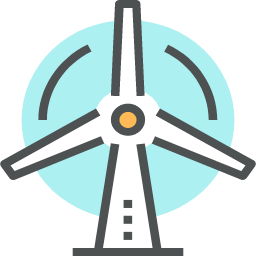
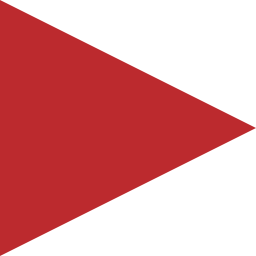
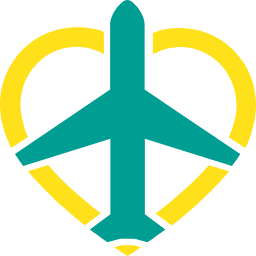


Sample 4:



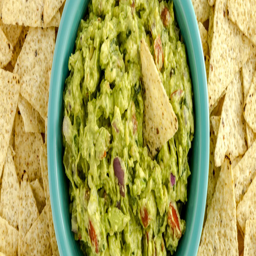
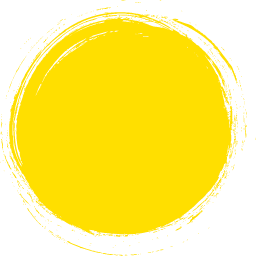
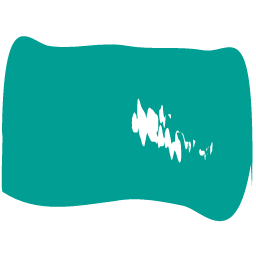
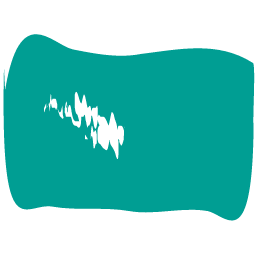
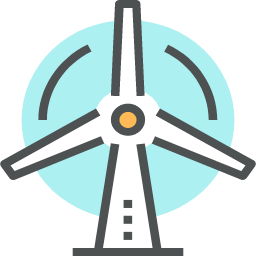
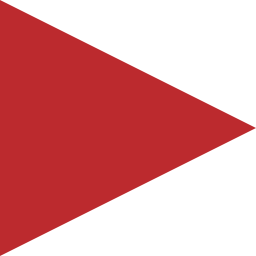


✓ Demo完成!


'\n# 切换到不同的任务类型\nconfig.target_task = "attr"  # 可选: elem, pos, attr, txt, img\n\nprint(f"\n切换任务类型为: {config.target_task}")\n\n# 重新运行可视化\nsvgs = visualize_reconstruction(\n    model, example, builders, config, input_columns,\n    type_mapping, font_mapping, width_mapping, height_mapping\n)\n\n# 显示结果\nprint(f"\n任务 {config.target_task} 的结果:")\ndisplay_comparison(svgs, [0, 1, 2, 3], config.column_names[config.target_task])\n'

In [2]:

svgs = visualize_reconstruction(
    model, example, builders, config, input_columns,
    type_mapping, font_mapping, width_mapping, height_mapping,
    bins=64  # 与dataset.py中的bins保持一致
)

print(f"\n✓ 生成了 {len(svgs)} 个样本的可视化结果")
print(f"列名: {config.column_names[config.target_task]}")


# ============================================================
# Cell 9: 显示结果（基础版）
# ============================================================
print("\n" + "="*80)
print("可视化结果:")
print("="*80)

for i, row in enumerate(svgs[:5]):  # 只显示前5个样本
    print(f"\nSample {i}:")
    display(HTML("<div style='margin: 10px 0;'>%s</div>" % " ".join(row)))

print("\n" + "="*80)
print("✓ Demo完成!")
print("="*80)


# ============================================================
# Cell 10 (可选): 单独显示某个样本
# ============================================================
"""
# 如果想单独查看某个样本，运行这个cell
sample_idx = 0  # 修改这个索引查看不同样本

print(f"Sample {sample_idx} - 详细视图")
print(f"列名: {config.column_names[config.target_task]}")

row = svgs[sample_idx]
for col_idx, col_name in enumerate(config.column_names[config.target_task]):
    if col_idx < len(row):
        print(f"\n{col_name}:")
        display(HTML(f"<div>{row[col_idx]}</div>"))
"""


# ============================================================
# Cell 11 (可选): 并排对比显示
# ============================================================
# def display_comparison(svgs, sample_indices, column_names):
#     """并排显示多个样本"""
#     html_parts = ['<table style="border-collapse: collapse; width: 100%;">']
    
#     # 表头
#     html_parts.append('<tr style="background-color: #f0f0f0;">')
#     html_parts.append('<th style="padding: 10px; border: 1px solid #ddd;">Sample</th>')
#     for col_name in column_names:
#         html_parts.append(f'<th style="padding: 10px; border: 1px solid #ddd;">{col_name}</th>')
#     html_parts.append('</tr>')
    
#     # 每一行
#     for idx in sample_indices:
#         if idx >= len(svgs):
#             continue
        
#         html_parts.append('<tr>')
#         html_parts.append(f'<td style="padding: 10px; border: 1px solid #ddd; text-align: center;"><b>#{idx}</b></td>')
        
#         row = svgs[idx]
#         for item in row:
#             html_parts.append(f'<td style="padding: 10px; border: 1px solid #ddd;">{item}</td>')
        
#         html_parts.append('</tr>')
    
#     html_parts.append('</table>')
    
#     display(HTML(''.join(html_parts)))


# # 显示前4个样本的对比
# print("\n" + "="*80)
# print("前4个样本对比:")
# print("="*80)
# display_comparison(svgs, [0, 1, 2, 3], config.column_names[config.target_task])


# ============================================================
# Cell 12 (可选): 调试信息
# ============================================================
"""
# 显示canvas尺寸的解码情况
print("\n" + "="*80)
print("Canvas尺寸调试信息:")
print("="*80)

for i in range(min(5, len(svgs))):
    canvas_w_idx = example['canvas_width'][i].item()
    canvas_h_idx = example['canvas_height'][i].item()
    
    canvas_w = width_mapping.get(canvas_w_idx, 800) if width_mapping else 800
    canvas_h = height_mapping.get(canvas_h_idx, 600) if height_mapping else 600
    
    print(f"\nSample {i}:")
    print(f"  Width:  idx={canvas_w_idx:3d} -> value={canvas_w}")
    print(f"  Height: idx={canvas_h_idx:3d} -> value={canvas_h}")
"""


# ============================================================
# Cell 13 (可选): 切换任务类型
# ============================================================
"""
# 切换到不同的任务类型
config.target_task = "attr"  # 可选: elem, pos, attr, txt, img

print(f"\n切换任务类型为: {config.target_task}")

# 重新运行可视化
svgs = visualize_reconstruction(
    model, example, builders, config, input_columns,
    type_mapping, font_mapping, width_mapping, height_mapping
)

# 显示结果
print(f"\n任务 {config.target_task} 的结果:")
display_comparison(svgs, [0, 1, 2, 3], config.column_names[config.target_task])
"""